# The art of using t-SNE for single-cell transcriptomics. Tutorial

This tutorial uses the data set from https://www.nature.com/articles/s41586-018-0654-5.

This notebook is self-contained. All functions that one needs to run this notebook are defined below.

Please install FIt-SNE from https://github.com/KlugerLab/FIt-SNE.

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

In [2]:
print('Python version', sys.version)
print('Numpy', np.__version__)
print('Matplotlib', matplotlib.__version__)
print('Seaborn', sns.__version__)
print('Pandas', pd.__version__)
print('Scipy', scipy.__version__)
print('Sklearn', sklearn.__version__)

Python version 3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Numpy 1.15.4
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4
Scipy 1.1.0
Sklearn 0.20.2


## Load the data
Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack. Direct links:
 * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
 * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

To get the information about cluster colors and labels (`sample_heatmap_plot_data.csv`), open the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse/v1-alm, go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV". For later reproducibility, this file is also provided in this github repository (`data` folder).

In [3]:
%%time

# Load the Allen institute data. This takes a few minutes

# This function is needed because using Pandas to load these files in one go 
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size
        
        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['../data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv',
             '../data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('../data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('../data/tasic-nature/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas, 
             'clusterColors': clusterColors, 'clusterNames': clusterNames}
counts = []

.............................................. done
.............................................. done
CPU times: user 3min 34s, sys: 9.13 s, total: 3min 43s
Wall time: 3min 35s


In [2]:
print('Number of cells:', tasic2018['counts'].shape[0])
print('Number of cells from ALM:', np.sum(tasic2018['areas']==0))
print('Number of cells from VISp:', np.sum(tasic2018['areas']==1))
print('Number of clusters:', np.unique(tasic2018['clusters']).size)
print('Number of genes:', tasic2018['counts'].shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(
    tasic2018['counts'].size/np.prod(tasic2018['counts'].shape)))

Number of cells: 23822
Number of cells from ALM: 9573
Number of cells from VISp: 14249
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


## Pre-processing

<IPython.core.display.Javascript object>


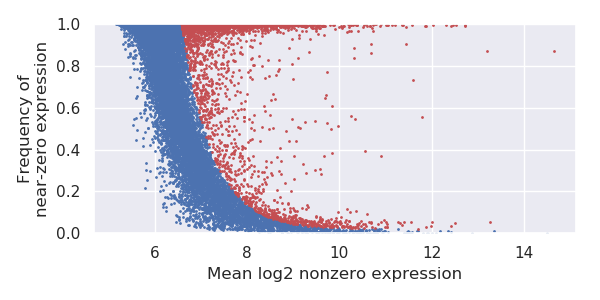

CPU times: user 33.8 s, sys: 4.55 s, total: 38.3 s
Wall time: 31.1 s


In [3]:
%%time

# Feature selection

def nearZeroRate(data, threshold=0):
    zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
    return zeroRate

def meanLogExpression(data, threshold=0, atleast=10):
    nonZeros = np.squeeze(np.array((data>threshold).sum(axis=0)))
    N = data.shape[0]
    A = data.multiply(data>threshold)
    A.data = np.log2(A.data)
    meanExpr = np.zeros(data.shape[1]) * np.nan
    detected = nonZeros >= atleast
    meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (nonZeros[detected]/N)
    return meanExpr
    
def featureSelection(meanLogExpression, nearZeroRate, yoffset=.02, decay=1.5, n=3000):
    low = 0; up=10    
    nonan = ~np.isnan(meanLogExpression)
    xoffset = 5
    for step in range(100):
        selected = np.zeros_like(nearZeroRate).astype(bool)
        selected[nonan] = nearZeroRate[nonan] > np.exp(-decay*meanLogExpression[nonan] + xoffset) + yoffset
        if np.sum(selected) == n:
            break
        elif np.sum(selected) < n:
            up = xoffset
            xoffset = (xoffset + low)/2
        else:
            low = xoffset
            xoffset = (xoffset + up)/2
    return selected

x = meanLogExpression(tasic2018['counts'], threshold=32)  # Get mean log non-zero expression of each gene
y = nearZeroRate(tasic2018['counts'], threshold=32)       # Get near-zero frequency of each gene
selectedGenes = featureSelection(x, y, n=3000)            # Adjust the threshold to select 3000 genes

plt.figure(figsize=(6,3))
plt.scatter(x[~selectedGenes], y[~selectedGenes], s=1)
plt.scatter(x[selectedGenes],  y[selectedGenes], s=1, color='r')
plt.xlabel('Mean log2 nonzero expression')
plt.ylabel('Frequency of\nnear-zero expression')
plt.ylim([0,1])
plt.tight_layout()

In [4]:
%%time

counts3k = tasic2018['counts'][:, selectedGenes]  # Feature selection

librarySizes = tasic2018['counts'].sum(axis=1)    # Compute library sizes
CPM = counts3k / librarySizes * 1e+6              # Library size normalisation

logCPM = np.log2(CPM + 1)                         # Log-transformation

pca = PCA(n_components=50, svd_solver='full').fit(logCPM)   # PCA

flipSigns = np.sum(pca.components_, axis=1) < 0             # fix PC signs
X = pca.transform(logCPM)
X[:, flipSigns] *= -1

print('Shape of the resulting matrix:', X.shape, '\n')

Shape of the resulting matrix: (23822, 50) 

CPU times: user 1min 11s, sys: 1.9 s, total: 1min 13s
Wall time: 20.1 s


## Initial data exploration (PCA/MDS)

<IPython.core.display.Javascript object>


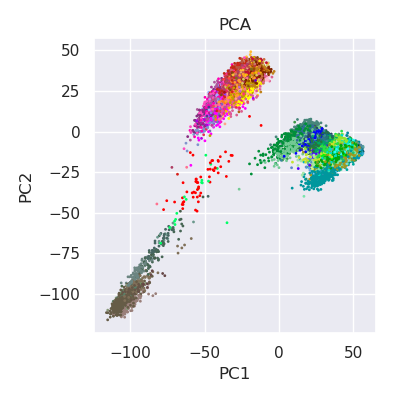

In [18]:
# Principal component analysis

plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], s=1, color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

<IPython.core.display.Javascript object>


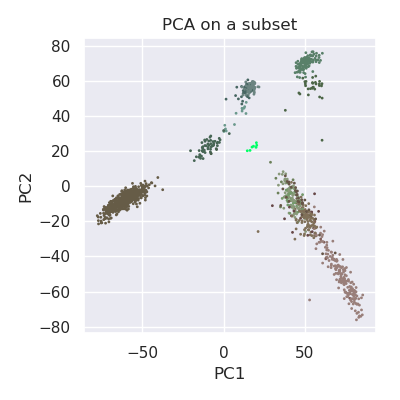

CPU times: user 256 ms, sys: 12 ms, total: 268 ms
Wall time: 68.7 ms


In [20]:
%%time

# PCA on a subset identified in the previous figure

subset = (X[:,0] < -50) & (X[:,1] < -50)
Xsubset = PCA(n_components=2).fit_transform(X[subset,:])

plt.figure(figsize=(4,4))
plt.scatter(Xsubset[:,0], Xsubset[:,1], s=1, 
            color=tasic2018['clusterColors'][tasic2018['clusters'][subset]])
plt.title('PCA on a subset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

<IPython.core.display.Javascript object>


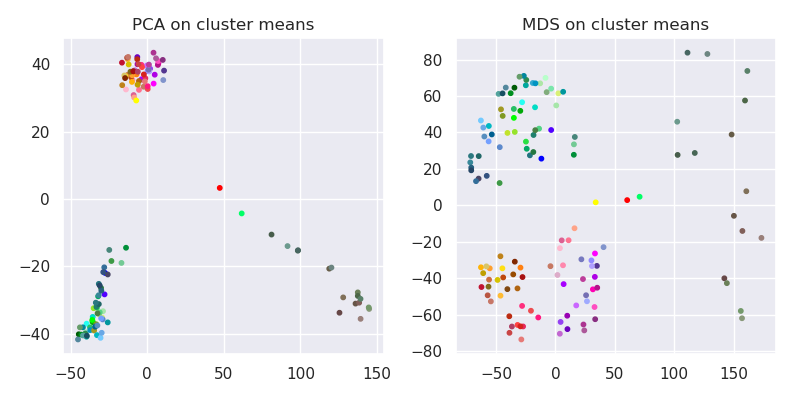

CPU times: user 1.58 s, sys: 20 ms, total: 1.6 s
Wall time: 411 ms


In [22]:
%%time

# If clustering results are available, do PCA and/or MDS on the cluster means

C = np.unique(tasic2018['clusters']).size
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018['clusters']==c,:], axis=0)

clusterMeansPCA = PCA(n_components=2, svd_solver='full').fit_transform(clusterMeans)
clusterMeansMDS = MDS(n_components=2, random_state=42).fit_transform(clusterMeans)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(clusterMeansPCA[:,0], clusterMeansPCA[:,1], s=10, color=tasic2018['clusterColors'])
plt.title('PCA on cluster means')
plt.subplot(122)
plt.scatter(clusterMeansMDS[:,0], clusterMeansMDS[:,1], s=10, color=tasic2018['clusterColors'])
plt.title('MDS on cluster means')
plt.tight_layout()

## Standard t-SNE visualisation 

CPU times: user 584 ms, sys: 108 ms, total: 692 ms
Wall time: 32.7 s


<IPython.core.display.Javascript object>


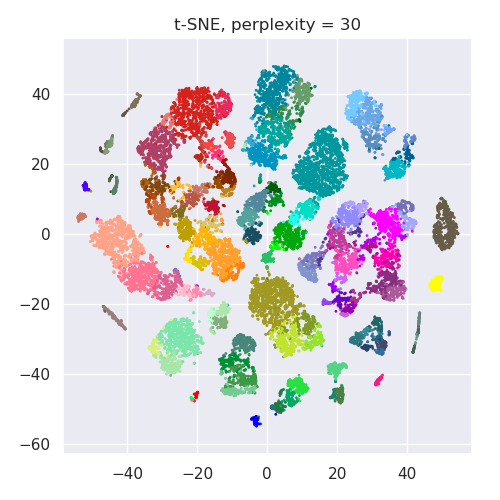

In [30]:
# This uses perplexity=30 (default) and random initialisation
# The result will depend on the random seed (here, 42)

%time tsne_default = fast_tsne(X, seed=42)  

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsne_default[:,0], tsne_default[:,1], s=1, 
            color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('t-SNE, perplexity = 30')
plt.tight_layout()

## Our recommended t-SNE settings
Here we use scaled PCA as initialisation, learning rate n/12, and the combination of perplexities 30 and n/100.

<IPython.core.display.Javascript object>


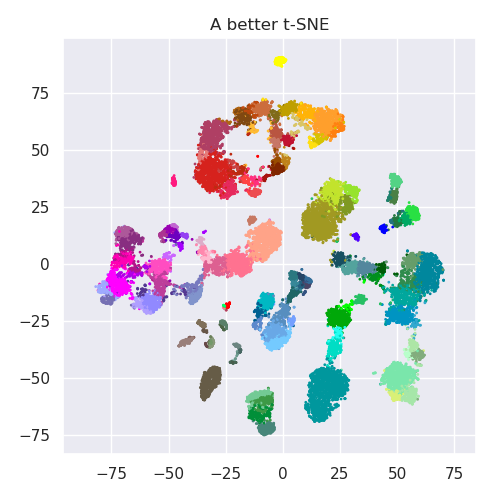

CPU times: user 896 ms, sys: 92 ms, total: 988 ms
Wall time: 2min 1s


In [33]:
%%time

pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001
tsne_ours = fast_tsne(X, initialization = pcaInit,
                      learning_rate = X.shape[0]/12,
                      perplexity_list = [30, int(X.shape[0]/100)])

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsne_ours[:,0], tsne_ours[:,1], s=1,
            color=tasic2018['clusterColors'][tasic2018['clusters']])
plt.title('A better t-SNE')
plt.tight_layout()

## Mapping new cells to an existing visualisation
We randomly select 100 cells as a "test set" and use all other cells as the "training set". We map the test set onto the t-SNE done on the training set.

In [41]:
# We use correlation across 3000 genes as the similarity metric to map test set points
# In this case we could use Euclidean distance as well, but in general correlaion should be
# more robust against possible batch effects, when mapping cells from other experiments

def map_to_tsne(referenceCounts, newCounts, referenceAtlas, knn=10, batchsize=1000):
    referenceCounts = np.array(np.log2(referenceCounts.todense() + 1))
    newCounts = np.array(np.log2(newCounts.todense() + 1))
    
    assignmentPositions = np.zeros((newCounts.shape[0], 2))
    batchCount = int(np.ceil(newCounts.shape[0]/batchsize))

    def corr2(A,B):
        A = A - A.mean(axis=1, keepdims=True)
        B = B - B.mean(axis=1, keepdims=True)
        ssA = (A**2).sum(axis=1, keepdims=True)
        ssB = (B**2).sum(axis=1, keepdims=True)
        C = np.dot(A, B.T) / np.sqrt(np.dot(ssA,ssB.T))
        return C
    
    for b in range(batchCount):
        if batchCount > 1:
            print('.', end='', flush=True) 
        batch = np.arange(b*batchsize, np.minimum((b+1)*batchsize, newCounts.shape[0]))
        C = corr2(newCounts[batch,:], referenceCounts)
        ind = np.argpartition(C, -knn)[:, -knn:]
        for i in range(batch.size):
            assignmentPositions[batch[i],:] = np.median(referenceAtlas[ind[i,:],:], axis=0)
    if batchCount > 1:
        print(' done')

    return assignmentPositions

In [38]:
%%time

# Randomly select 100 points as the test set
testSet     = np.random.choice(X.shape[0], 100)
trainingSet = np.array([i for i in range(X.shape[0]) if i not in testSet])

# Run t-SNE on the training set
pca = PCA(n_components=50, svd_solver='full').fit(logCPM[trainingSet,:])
flipSigns = np.sum(pca.components_, axis=1) < 0             
Xtrain = pca.transform(logCPM[trainingSet,:])
Xtrain[:, flipSigns] *= -1
pcaInit_train = Xtrain[:,:2] / np.std(Xtrain[:,0]) * 0.0001
tsneTrain = fast_tsne(Xtrain, initialization = pcaInit_train,
                      learning_rate = Xtrain.shape[0]/12,
                      perplexity_list = [30, int(Xtrain.shape[0]/100)])

CPU times: user 1min 9s, sys: 1.92 s, total: 1min 11s
Wall time: 2min 17s


In [42]:
%%time

# Map test points to the training t-SNE
pos = map_to_tsne(tasic2018['counts'][:,selectedGenes][trainingSet,:],
                  tasic2018['counts'][:,selectedGenes][testSet,:],
                  tsneTrain)

CPU times: user 3.33 s, sys: 904 ms, total: 4.23 s
Wall time: 1.91 s


<IPython.core.display.Javascript object>


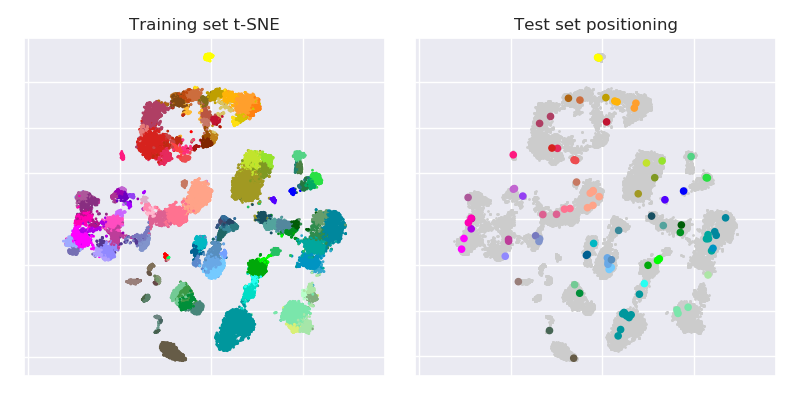

In [43]:
# Plot

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsneTrain[:,0], tsneTrain[:,1], s=1, 
            color=tasic2018['clusterColors'][tasic2018['clusters']][trainingSet])
plt.title('Training set t-SNE')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsneTrain[:,0], tsneTrain[:,1], s=1, color=[.8,.8,.8])
plt.scatter(pos[:,0], pos[:,1], s=20, 
            color=tasic2018['clusterColors'][tasic2018['clusters']][testSet])
plt.title('Test set positioning')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

## Aligned t-SNE visualisations
We randomly select 2000 cells as a "data set 1" and use all other cells as the "data set 2". We perform t-SNE of the first data set, then map the second data set on the resulting t-SNE and use this mapping as initialisation to run t-SNE on the second dataset.

In [53]:
%%time

# Randomly select 2000 points as one dataset and the rest as another

set1 = np.random.choice(X.shape[0], 2000)
set2 = np.array([i for i in range(X.shape[0]) if i not in set1])

# Run t-SNE on data set 1

pca = PCA(n_components=50, svd_solver='full').fit(logCPM[set1,:])
flipSigns = np.sum(pca.components_, axis=1) < 0             
X1 = pca.transform(logCPM[set1,:])
X1[:, flipSigns] *= -1

pcaInit1 = X1[:,:2] / np.std(X1[:,0]) * 0.0001
tsne1 = fast_tsne(X1, perplexity=50, initialization=pcaInit1)

# Map data set 2 to this t-SNE

pos = map_to_tsne(tasic2018['counts'][:,selectedGenes][set1,:],
                  tasic2018['counts'][:,selectedGenes][set2,:],
                  tsne1)

alignInit = pos / np.std(pos[:,0]) * 0.0001

# Run t-SNE of data set 2

pca = PCA(n_components=50, svd_solver='full').fit(logCPM[set2,:])
flipSigns = np.sum(pca.components_, axis=1) < 0             
X2 = pca.transform(logCPM[set2,:])
X2[:, flipSigns] *= -1
tsne2 = fast_tsne(X2, initialization = alignInit,
                      learning_rate = X2.shape[0]/12,
                      perplexity_list = [30, int(X2.shape[0]/100)])

...................... done
CPU times: user 1min 37s, sys: 3.22 s, total: 1min 40s
Wall time: 2min 32s


<IPython.core.display.Javascript object>


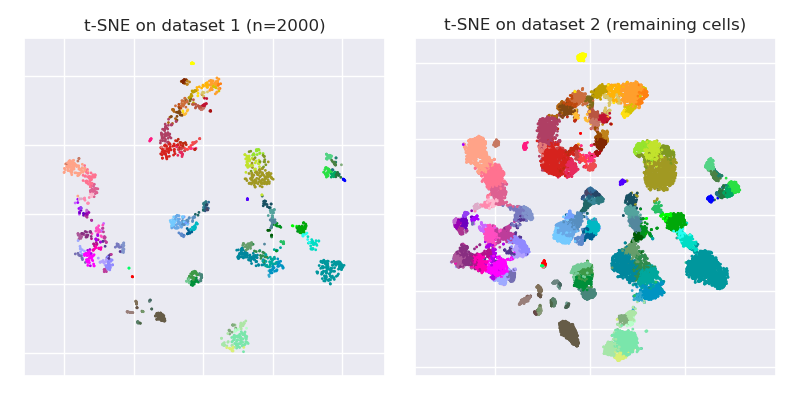

In [54]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsne1[:,0], tsne1[:,1], s=1, 
            color=tasic2018['clusterColors'][tasic2018['clusters'][set1]])
plt.title('t-SNE on dataset 1 (n=2000)')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

plt.subplot(122)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(tsne2[:,0], tsne2[:,1], s=1, 
            color=tasic2018['clusterColors'][tasic2018['clusters'][set2]])
plt.title('t-SNE on dataset 2 (remaining cells)')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

## Huge data sets
Here we create a simulate large dataset by replicating each cell in the Tasic et al. data 10 times and adding Gaussian noise in the space of the first 50 PCs. The resulting dataset has N = 238,000 cells. We assume that this dataset is of such size that we cannot use any perplexity that is much larger than default (30). So we are only using default perplexity here.

Our approach uses downsampling-based initialisation.

In [5]:
# Simulate the dataset

X_huge = X.copy()
clusters_huge = tasic2018['clusters'].copy()
for i in range(9):
    X_huge = np.concatenate((X_huge,X))
    clusters_huge = np.concatenate((clusters_huge, tasic2018['clusters']))
X_huge += np.random.randn(*X_huge.shape) * 1.5

print('Simulated dataset size:', X_huge.shape)

Simulated dataset size: (238220, 50)


In [6]:
# This uses Euclidean distance in the PCA space. Only points that were not in the downsampled subset
# are positioned on the downsampled tSNE.

def map_to_downsampled_tsne(X, Z, downsampled_ind, batchsize=1000, knn=10):
    ind_rest = np.where(~np.isin(np.arange(X.shape[0]), downsampled_ind))[0]
    steps = int(np.ceil(ind_rest.size/batchsize))
    assignmentPositions = np.zeros((X.shape[0], 2))
    assignmentPositions[downsampled_ind,:] = Z
    
    def pdist2(A,B):
        return np.sum(A**2,axis=1)[:, None] + np.sum(B**2, axis=1)[None, :] - 2 * A @ B.T

    for i in range(steps):
        print('.', end='', flush=True)
        endind = np.min(((i+1)*batchsize, ind_rest.size))
        batch = ind_rest[i*batchsize:endind]
        D = pdist2(X[batch, :], X[downsampled_ind,:])
        ind = np.argpartition(D, knn)[:, :knn]
        for i in range(batch.size):
            assignmentPositions[batch[i],:] = np.median(Z[ind[i,:],:], axis=0)
    print('', flush=True)
    
    return assignmentPositions


# Pipeline for using downsampling-based initialisation
def downsampling_based_tsne(X, subsetSize=25000, seed=42, exaggeration=1):
    np.random.seed(seed)
    indSubset = np.random.choice(X.shape[0], subsetSize, replace=False)
    
    # Note that this assumes that X was already PCA-transformed
    pcaInit = X[:,:2] / np.std(X[:,0]) * 0.0001
    
    Zsubset = fast_tsne(X[indSubset,:], perplexity_list=[30, int(subsetSize/100)], 
                        initialization = pcaInit[indSubset,:],
                        learning_rate = subsetSize/12)

    pos = map_to_downsampled_tsne(X, Zsubset, indSubset)
    downsampled_init = pos / np.std(pos[:,0]) * 0.0001

    Z = fast_tsne(X, perplexity=30, initialization=downsampled_init, 
                  learning_rate=X.shape[0]/12, late_exag_coeff=exaggeration, 
                  start_late_exag_iter=250)
    
    return Z

In [9]:
%%time

# t-SNE with PCA initialisation and high learning rate (perplexity 30)
pcaInit = X_huge[:,:2] / np.std(X_huge[:,0]) * 0.0001
tsne1 = fast_tsne(X_huge, initialization=pcaInit, learning_rate=X_huge.shape[0]/12)

# t-SNE with downsampling-based initialisation and exaggeration
tsne2 = downsampling_based_tsne(X_huge, exaggeration=4)

......................................................................................................................................................................................................................
CPU times: user 5min 14s, sys: 33.4 s, total: 5min 48s
Wall time: 13min 41s


<IPython.core.display.Javascript object>


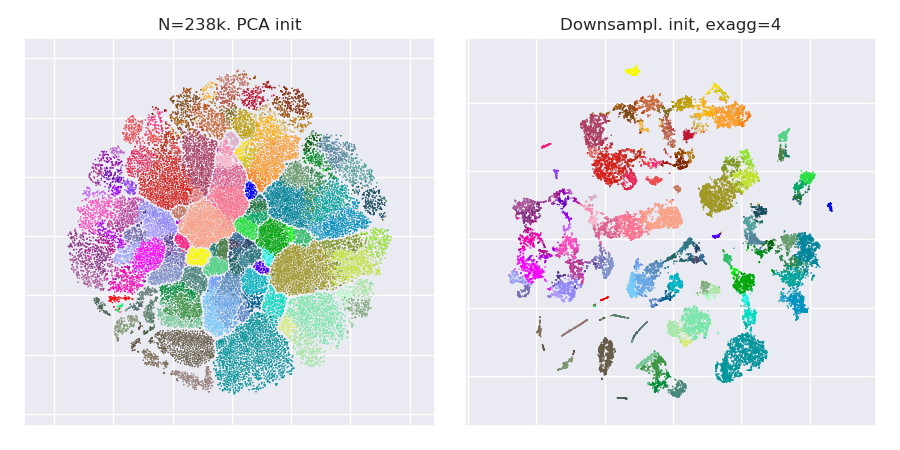

In [10]:
# Plot

tsnes  = [tsne1, tsne2]
titles = ['N=238k. PCA init', 'Downsampl. init, exagg=4']

plt.figure(figsize=(9,4.5))
for i,t in enumerate(tsnes):
    plt.subplot(1,2,i+1)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.scatter(tsnes[i][:,0], tsnes[i][:,1], s=1, alpha=.2, edgecolor='none',
                color=tasic2018['clusterColors'][clusters_huge])
    plt.title(titles[i])
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    
plt.tight_layout()